# Optimal number of edges

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from echo import esn

Task:

* Let's compare 3 types of networks:
  1. With `alternating` positive and negative weights
  1. With `distributed` inhibition, where sum(of the entire matrix) = 0, as all 0s (except those on the diagonal) are replaced with -inhibition/n_unoccupied_cells
  1. With `balaned_out` matrix, where every neuron outputs a net sum of 0, as all not-connections are replaced with negative values to balance total output to 0. Except if this neuron outputs all 0s or all 1s, as these conditions are impossible to balance. 
    * _This option is weird, and I'm only trying it to see if it's awesome. But if it is not awesome (and the simulations below show that it is not awesome), then there's no reason to stick with it, as it is weird, and hard to explain_
    
* And for every network type, let's find the optimal number of edges.

Comments:
* Here we train and test everything on same two arbitrarily selected Lorenzes data, to honestly see how much variability comes from the model itseld.

Conclusions:
* Going to `distributed` inhibition increases the loss a lot (about 3 times), but even then, some graphs produce decent losses. So maybe it's harder to stumble upon a solution, but solutions do seem to exist.
  * Why is distributed inhibition less efficient? There are several possibilities:
    1. Maybe inhibition is just weak, and more neurons have to collaborate in order to produce strong enough inhibition, which means that a 100-node network in practic operates like a 50-node network or something
    2. Maybe it's primarily because of input weights being flat, so some nodes are "waisted" on flipping the sign of the signal
    3. Or maybe this network is just more sensitive to organization, and we really need to optimize it a bit
    4. Finally, maybe it's just bad, whatever you do
* To test 2nd option, we can combine "distributed" internal weights witn "alternating" input weights.
  * The experiment below shows that it doesn't matter, which means that (2) is incorrect, and it's either option 1, 3, or 4.
* `balanced_in` inhibition type is problematic as it doesn't work with "flat": if all nodes get the same external output, and the sum of input weights to each node ==0, then the model stays in 0 forever. Switching input weignts to `alternating` fixes it, but we don't want two types of input nodes, so it's easier to just ignore `balanced_in` as an option.
* While for alternating edges, optimal performance happened around 700 edges in a 100-nodes network (~15% of all possible edges), for distributed inhibition performance is almost completely flat. Which suggests that at least for networks of this size, ~40% of all possible edges may be a good value.

In [2]:
# Experiments with rho, with fixed normalization strength

data = esn.Data.create_source('lorenz')

points_to_skip = 300
training_signal_length = 10000
test_length = 1000
n_units = 100
rho = 0.8           # 0.8 is optimal for alternating weights
l2 = 0.0001         # Optimal value seems ot be 0, but that feeils weird
n_experiments = 20

n_edgeses = list(range(100,5000, 500))
modes = [('alternating','alternating'), ('distributed','flat'), ('balanced_out','flat'), ('distributed','alternating')]

loss_train = np.zeros((len(modes), len(n_edgeses), n_experiments))
loss_test = np.zeros(loss_train.shape)

seeds = np.random.uniform(size=n_experiments) # We always train on same data, but with different networks

for (j, mode) in enumerate(modes):
    for (i, n_edges) in enumerate(n_edgeses):
        for i_exp in range(n_experiments):
            #seed = seeds[i_exp]
            seed = [1,0,0]
            x1,y1 = data.generate(points_to_skip + training_signal_length, seed=seed)
            x2,y2 = data.generate(points_to_skip + training_signal_length, seed=[10,5,5])

            model = esn.Reservoir(n_units, n_edges=n_edges, rho=rho, l2=l2, network_type='erdos',            
                                   inhibition=mode[0], weights_in=mode[1])            
            model.fit(x1, y1, skip=points_to_skip)

            # Training data loss    
            z = model.predict(x1, length=points_to_skip+test_length)     
            loss_train[j, i, i_exp] = esn.utils.loss(y1[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])        

            # Testing loss        
            z = model.predict(x2, length=points_to_skip+test_length)     
            loss_test[j, i, i_exp] = esn.utils.loss(y2[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])
            print('.', end='')
        print(';', end='')
    print('|', end='')
print('\nDone')

....................;....................;....................;....................;....................;....................;....................;....................;....................;....................;|....................;....................;....................;....................;....................;....................;....................;....................;....................;....................;|....................;....................;....................;....................;....................;....................;....................;....................;....................;....................;|....................;....................;....................;....................;....................;....................;....................;....................;....................;....................;|
Done


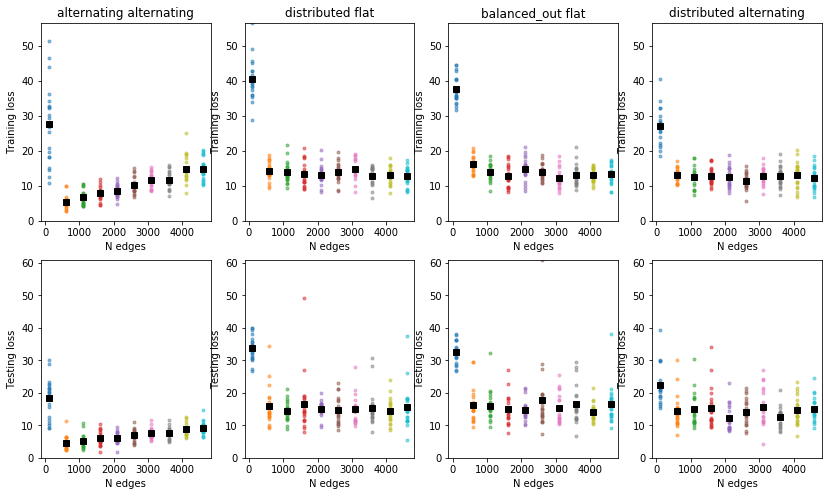

In [3]:
# Transsections
def plot1d(xs, y, xlabel=None, ylabel=None, title=None):
    y = np.squeeze(y) # We expect sngleton dimensions here    
    for i,x in enumerate(xs):
        plt.plot(x*np.ones(y.shape[1]), y[i,:], '.', alpha=0.5)
        plt.plot(x, np.mean(y[i,:]), 'sk')    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
        
plt.figure(figsize=(14,8))
titles = ['']
ntypes = loss_train.shape[0]
for j in range(ntypes):
    plt.subplot(2, ntypes, j+1)
    plot1d(n_edgeses, loss_train[j,...], 'N edges', 'Training loss')
    plt.ylim([0, max(loss_train.flatten())])
    plt.title(' '.join(modes[j]))
    plt.subplot(2, ntypes, j+1+ntypes)
    plot1d(n_edgeses, loss_test[j,...], 'N edges', 'Testing loss')
    plt.ylim([0, max(loss_test.flatten())])